In [1]:
import spacy
import csv
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc
from sklearn.preprocessing import StandardScaler

nlp = spacy.load("en_core_web_sm", exclude=['tok2vec', 'parser', 'senter', 'ner'])


In [2]:
def filterType(token):
    return token.is_alpha and not (token.is_stop or token.like_num or token.is_punct) and len(token.lemma_) > 3

In [3]:
with open('./covid19_preprints/data/covid19_preprints.csv') as csvfile:
    csvreader = csv.DictReader(csvfile)
    
    docs = [[token.lemma_ for token in doc if filterType(token)] for doc in nlp.pipe((row["abstract"] for row in csvreader), batch_size=1000, n_process=3)]
dictionary = Dictionary(docs)
dicted_docs = [dictionary.doc2bow(text) for text in docs]
lda = LdaMulticore(dicted_docs, id2word=dictionary, num_topics=10)

In [4]:
topics = corpus2csc(lda[dicted_docs]).T
topics_nomalized = StandardScaler().fit_transform(topics.todense())

In [5]:
lda.show_topics()

[(0,
  '0.023*"patients" + 0.009*"study" + 0.007*"pandemic" + 0.007*"health" + 0.007*"data" + 0.007*"disease" + 0.006*"clinical" + 0.005*"cases" + 0.005*"severe" + 0.005*"coronavirus"'),
 (1,
  '0.011*"sars" + 0.007*"disease" + 0.007*"patients" + 0.005*"based" + 0.005*"cases" + 0.005*"pandemic" + 0.005*"health" + 0.005*"study" + 0.005*"data" + 0.005*"coronavirus"'),
 (2,
  '0.014*"pandemic" + 0.010*"model" + 0.008*"data" + 0.008*"health" + 0.007*"social" + 0.006*"number" + 0.006*"cases" + 0.005*"economic" + 0.005*"countries" + 0.005*"disease"'),
 (3,
  '0.008*"sars" + 0.006*"pandemic" + 0.006*"study" + 0.006*"transmission" + 0.005*"patients" + 0.005*"face" + 0.005*"test" + 0.004*"based" + 0.004*"data" + 0.004*"results"'),
 (4,
  '0.010*"sars" + 0.009*"patients" + 0.007*"health" + 0.006*"disease" + 0.006*"pandemic" + 0.006*"data" + 0.005*"study" + 0.005*"model" + 0.004*"coronavirus" + 0.004*"vaccine"'),
 (5,
  '0.010*"risk" + 0.008*"social" + 0.007*"distancing" + 0.006*"infection" + 0.0

In [6]:
from sklearn.manifold import TSNE
twod = TSNE(n_components=2, n_jobs=-1).fit_transform(topics_normalized)

In [7]:
%%time
import umap
import umap.plot
reducer = umap.UMAP()
embedding = reducer.fit_transform(topics_normalized)

CPU times: user 3min 45s, sys: 28.9 s, total: 4min 14s
Wall time: 1min 47s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

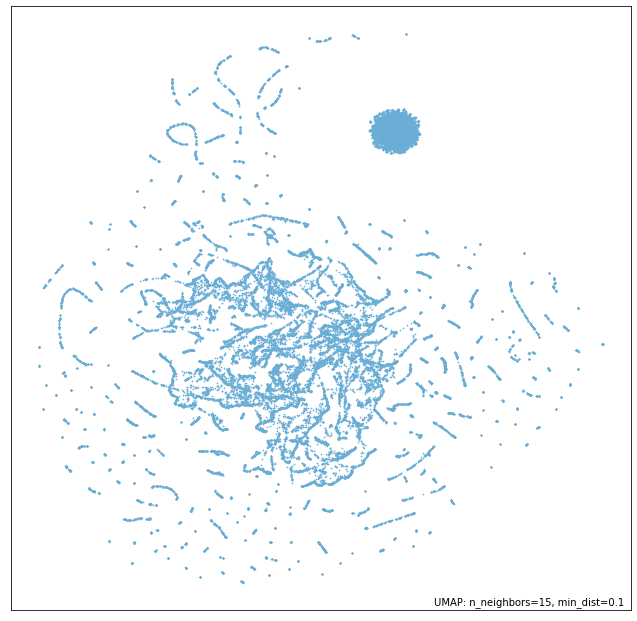

In [8]:
umap.plot.points(reducer)

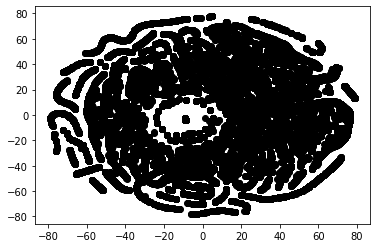

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(twod[:,0], twod[:,1], 'o', color='black');

[[('patients', 0.023293182253837585),
  ('study', 0.008773500099778175),
  ('pandemic', 0.007323324214667082),
  ('health', 0.0070734149776399136),
  ('data', 0.007034761365503073),
  ('disease', 0.006777882110327482),
  ('clinical', 0.0059307231567800045),
  ('cases', 0.005331715103238821),
  ('severe', 0.005084692500531673),
  ('coronavirus', 0.005011172033846378)],
 [('sars', 0.011288571171462536),
  ('disease', 0.007370124105364084),
  ('patients', 0.00681542232632637),
  ('based', 0.005388809368014336),
  ('cases', 0.005344969220459461),
  ('pandemic', 0.005333390552550554),
  ('health', 0.005305715370923281),
  ('study', 0.005027759354561567),
  ('data', 0.004850965458899736),
  ('coronavirus', 0.004537852481007576)],
 [('pandemic', 0.013969661667943),
  ('model', 0.009666571393609047),
  ('data', 0.008025353774428368),
  ('health', 0.007510213181376457),
  ('social', 0.006866341456770897),
  ('number', 0.006142166908830404),
  ('cases', 0.005855385214090347),
  ('economic', 0.00

In [15]:
import json
with open('./covid19_preprints/data/covid19_preprints.csv') as csvfile:
    with open('./data/extended_covid_preprints.json', 'w+') as jsonfile:
        csvreader = csv.DictReader(csvfile)
        
        projects = [{"tsne_coordinates":tsnecoord, "umap_coordinates": umapcoord, **row} for row, tsnecoord, umapcoord in zip(csvreader,twod.tolist(), embedding.tolist())]
        
        

        json.dump({
            "lda_topics": [[(word, float(importance))for word, importance in topic] for num,topic in lda.show_topics(formatted=False)],
            "projects": projects
        }, jsonfile)